# Batchfitting of multiple datasets

This notebook is a demonstration of how to batch fit multiple datasets using `refnx`. Batch fitting is essential for bulk analysis of hundreds or thousands of datasets. Such situations are becoming more common as faster instruments (such as those being built at the ESS) come online.
This example is based on a deuterated polymer film that is gradually being swollen by an hydrogenous solvent. 314 datasets were acquired over a period of a couple of hours.

In [1]:
# some initial imports
%matplotlib inline
import time
from multiprocessing import Pool
from copy import deepcopy
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np

In [2]:
# the refnx imports
import refnx
from refnx.dataset import Data1D
from refnx.analysis import Objective, CurveFitter
from refnx.reflect import SLD, Slab, ReflectModel, Structure
from refnx.dataset import ReflectDataset

# we print out the version so that others can repeat our analysis
print(refnx.version.version)

# natsort is used for alphanumeric sort, but it's not essential
# An alphanumeric sort typically ensures that the datasets are loaded in
# the order in which they were run.
files = natsorted(list(glob.iglob('./*.dat')))

"""
initial model setup
"""
# set up the SLD objects for each layer
air = SLD(0.0 + 0.0j, name='air_sld')
polymer = SLD(6.14127029941648 + 0.0j, name='d-polymer')
sio2 = SLD(3.47 + 0.0j, name='native SiO2')
si = SLD(2.07 + 0.0j, name='Si')

# set up Slabs corresponding to each layer
polymer_l = Slab(520.5277261491321, polymer, 8.762992087388763, name='polymer layer')
sio2_l = Slab(15.305814908968332, sio2, 5.020239736927396, name='sio2 layer')
si_l = Slab(0.0, si, 3.0, name='Si')

# SLD limits for polymer film
polymer.real.setp(vary=True, bounds=(0, 7.0))

# limits for thickness and roughness of the layers
polymer_l.thick.setp(vary=True, bounds=(200, 1020.0))
polymer_l.rough.setp(vary=True, bounds=(2.0, 20.0))
sio2_l.thick.setp(vary=True, bounds=(5.0, 10.0))
sio2_l.rough.setp(vary=True, bounds=(2.0, 10.0))

# set up the Structure object from the Slabs
structure = air | polymer_l | sio2_l | si_l

# make the reflectometry model
model = ReflectModel(structure, scale=1.0, bkg=1e-10, dq=8.6, dq_type='constant')
model.scale.setp(vary=True, bounds=(0.5, 1.5))
model.bkg.setp(vary=True, bounds=(1e-10, 1e-5))

"""
Create lists of all the objectives to fit
"""
filenames = []
models = []
objectives = []

for idx, file in enumerate(files):
    data = Data1D(data=file)

    # make the objective for each dataset. Deepcopy is used so that all the
    # models are independent of each other
    objective = Objective(deepcopy(model), data)

    filenames.append(data.filename)
    models.append(objective.model)
    objectives.append(objective)

0.1.45


Since all the objectives and curvefits are independent we can fit the datasets in parallel. To do this in Python one can use a [`multiprocessing.Pool`](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool) object to map over all the datasets. Use of a `Pool` object requires us to create a `fit_an_objective` function in a separate Python file to fit each objective (this is because the function needs to be pickleable). The `tqdm` package can be used to display a progress bar.

In [3]:
from parallel_curvefitter import fit_an_objective
"""
# parallel_curvefitter.py

def fit_an_objective(objective):
    # make the curvefitter and do the fit
    fitter = CurveFitter(objective)
    fitter.fit('differential_evolution', verbose=False, tol=0.05)
    return objective
"""

with Pool() as p:
    obj_out = list(p.map(fit_an_objective, tqdm(objectives)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 314/314 [00:46<00:00,  6.77it/s]


We fitted all 314 datasets in 46"" (using an M3 Macbook Pro), which is 0.15 seconds per fit. If we had fitted in a serial manner this would have taken a lot longer.

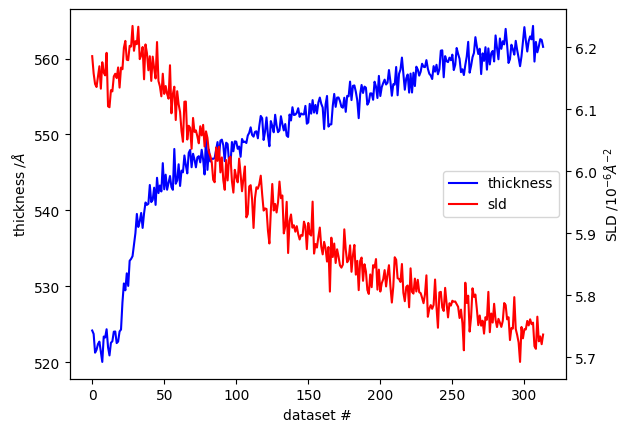

In [4]:
# now process the output
thickness = []
sld = []
for objective in obj_out:
    model = objective.model
    thickness.append(model.structure[1].thick.value)
    sld.append(model.structure[1].sld.real.value)

fig, ax1 = plt.subplots()
ax1.set_xlabel('dataset #')
ax1.set_ylabel('thickness /$\\AA$')
l_0 = ax1.plot(thickness, 'b', label='thickness')
ax2 = ax1.twinx()
l_1 = ax2.plot(sld, 'r', label='sld')
ax2.set_ylabel('SLD /$10^{-6}\\AA^{-2}$');

# setup the legend
lines = l_0 + l_1
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='right');

Here we see an induction period during which the film thickness and SLD remains constant (even a possible loss of solvent?). After this period the the thickness grows rapidly before with the rate than slowing down. The SLD has a continuous decrease, but the decrease is not significantly faster during the period in which the thickness of the film grows rapidly.